In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
task = mnist.MNIST()
task.load_all_data(device)

In [4]:
torch.manual_seed(13)
np.random.seed(13)
model = models_pheno.MassiveConvNet

# for trial_idx in tqdm(range(n_trials)):
net = model().to(device)
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
loop = tqdm(range(30))

vecs = []
for epoch_idx in loop:
    for X_batch, Y_batch in zip([task.X_train[10000*i:10000*(i+1)] for i in range(6)], [task.Y_train[10000*i:10000*(i+1)] for i in range(6)]):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        Y_batch_pred = net(X_batch)
        loss = task.loss_func(Y_batch_pred, Y_batch)
        opt.zero_grad()
        loss.backward()
        opt.step()

    fitdata = task.calc_pheo_fitness(net, n_sample=None, device=device)
    loop.set_postfix(fitdata)
    vecs.append(util.model2vec(net).detach().clone())

vecs = torch.stack(vecs)

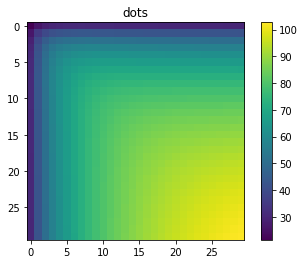

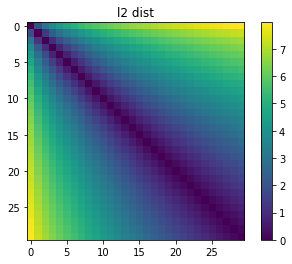

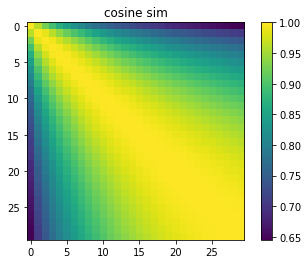

In [28]:
def compare_vec_seqs(vecs1, vecs2):
    a, b = vecs[None], vecs[:, None]

    dots = vecs@vecs.T
    l2_dists = (a-b).norm(dim=-1)
    sim = torch.cosine_similarity(a, b, dim=-1)

    plt.imshow(dots.cpu().numpy());plt.title('dots');plt.colorbar();plt.show()
    plt.imshow(l2_dists.cpu().numpy());plt.title('l2 dist');plt.colorbar();plt.show()
    plt.imshow(sim.cpu().numpy());plt.title('cosine sim');plt.colorbar();plt.show()
    
compare_vec_seqs(vecs, vecs)

In [6]:
fds_epoch = []
for vec in tqdm(vecs):
    fds_epoch.append(task.calc_pheo_fitness(util.vec2model(vec, net), n_sample=None, device=device))
fds_epoch = np.array(fds_epoch)

In [14]:
for start_i in range(1):
    fds = []
    for i in tqdm(torch.linspace(0, 1, 30), leave=False):
        vec = vecs[start_i]*(1-i) + vecs[-1]*i
        fds.append(task.calc_pheo_fitness(util.vec2model(vec, net), n_sample=None, device=device))
    fds = np.array(fds)
#     plt.plot(util.arr_dict2dict_arr(fds)['loss'], label=f'start_i {start_i}')
# plt.legend()
# plt.show()

Text(0.5, 1.0, 'netowrk loss and lin interpolated network loss vs epoch')

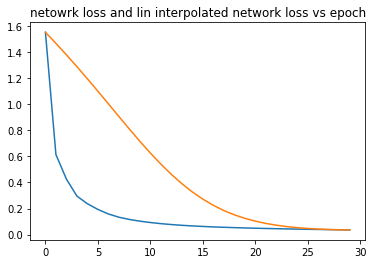

In [18]:
plt.plot(util.arr_dict2dict_arr(fds_epoch)['loss'])
plt.plot(util.arr_dict2dict_arr(fds)['loss'])
plt.title('netowrk loss and lin interpolated network loss vs epoch')

Text(0.5, 1.0, 'Gradient magnitude vs epoch')

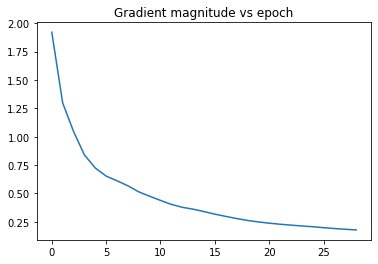

In [17]:
grads = (vecs[1:]-vecs[:-1])
plt.plot(grads.norm(dim=-1).cpu().numpy())
plt.title('Gradient magnitude vs epoch')

In [29]:
vec_linspace = torch.stack([vecs[0]*(1-i)+vecs[-1]*i for i in torch.linspace(0, 1, 30)]).shape

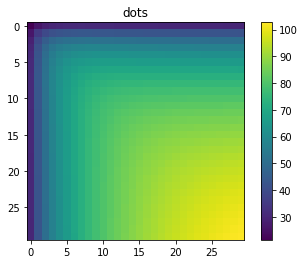

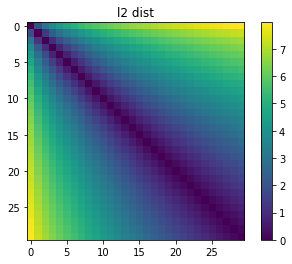

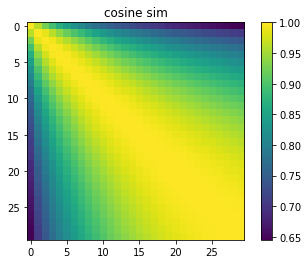

In [30]:
compare_vec_seqs(vecs, vec_linspace)

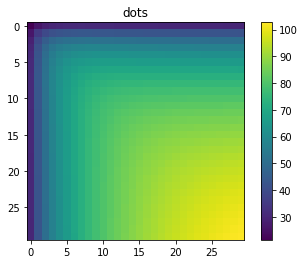

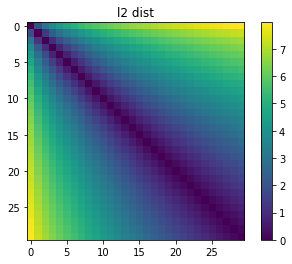

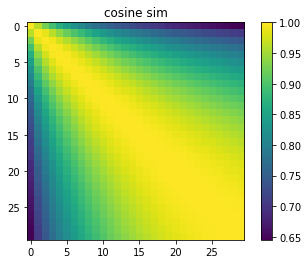

In [32]:
compare_vec_seqs(grads, grads)